<a href="https://colab.research.google.com/github/AI-AVENGER-S/ML-Practices/blob/main/PyTorch_Computer_Vision_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import userdata
import os


os.environ['KAGGLE_USERNAME'] = userdata.get('KAGGLE_USERNAME')
os.environ['KAGGLE_KEY'] = userdata.get('KAGGLE_KEY')

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.28G/2.29G [00:13<00:00, 261MB/s]
100% 2.29G/2.29G [00:13<00:00, 188MB/s]


In [3]:
import zipfile
import os

zip_path = 'chest-xray-pneumonia.zip'
extract_path = 'chest_xray_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print('распаковка сделана')

распаковка сделана


In [4]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_data(dataset, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        idx = np.random.randint(0, len(dataset))
        img, label = dataset[idx]

        img = img.permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title('Pneumonia' if label == 1 else 'Normal')
        plt.axis('off')
    plt.show()

In [5]:
base_path = 'chest_xray_data/chest_xray/chest_xray'
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')
val_dir = os.path.join(base_path, 'val')

In [6]:
train_dir

'chest_xray_data/chest_xray/chest_xray/train'

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"всего папок : {train_dataset.classes}")
print(f"картинок для обучения: {len(train_dataset)}")
print(f"картинок для валидации: {len(val_dataset)}")
print(f"картинок для теста: {len(test_dataset)}")

всего папок : ['NORMAL', 'PNEUMONIA']
картинок для обучения: 5216
картинок для валидации: 16
картинок для теста: 624


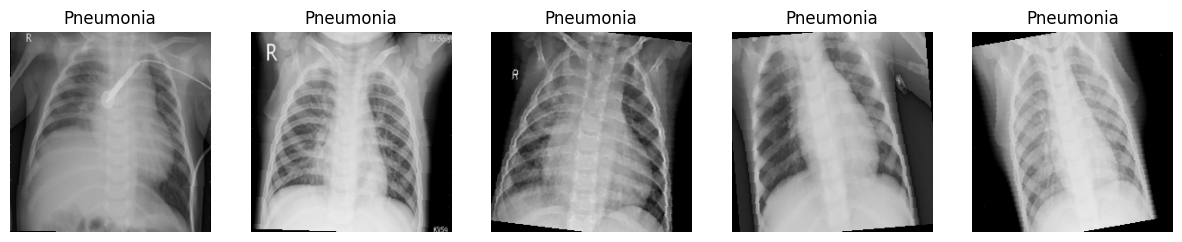

In [8]:
visualize_data(train_dataset, n=5)

In [9]:
import torch.nn as nn


class PneumoniaCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            self._make_layer(3, 16),
            self._make_layer(16, 32),
            self._make_layer(32, 64),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 2)
        )

    def _make_layer(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        return self.classifier(x)

In [10]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"используем: {device}")

используем: cuda


In [11]:
model_v1 = PneumoniaCNN().to(device)

In [12]:
model_v1

PneumoniaCNN(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Flatten(start_

In [13]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v1.parameters(), lr=0.001)

In [14]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [15]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / len(loader), 100. * correct / total

In [20]:
epochs = 4
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model_v1, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model_v1, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print('-' * 30)

Epoch 1/4:
Train Loss: 0.0945 | Train Acc: 96.66%
Val Loss: 0.7199 | Val Acc: 79.06%
------------------------------
Epoch 2/4:
Train Loss: 0.0871 | Train Acc: 96.70%
Val Loss: 0.8646 | Val Acc: 75.94%
------------------------------
Epoch 3/4:
Train Loss: 0.0732 | Train Acc: 97.20%
Val Loss: 0.5393 | Val Acc: 82.50%
------------------------------
Epoch 4/4:
Train Loss: 0.0752 | Train Acc: 97.32%
Val Loss: 1.7369 | Val Acc: 67.50%
------------------------------


In [21]:
from torch.utils.data import DataLoader, ConcatDataset, random_split

base_path = 'chest_xray_data/chest_xray/chest_xray'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_folder_ds = datasets.ImageFolder(val_dir, transform=test_transforms)
test_folder_ds = datasets.ImageFolder(test_dir, transform=test_transforms)

combined_temp_ds = ConcatDataset([val_folder_ds, test_folder_ds])

val_size = len(combined_temp_ds) // 2
test_size = len(combined_temp_ds) - val_size

val_dataset, test_dataset = random_split(
    combined_temp_ds,
    [val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Обучение: {len(train_dataset)} картинок")
print(f"Валидация: {len(val_dataset)} картинок")
print(f"Тест: {len(test_dataset)} картинок")

Обучение: 5216 картинок
Валидация: 320 картинок
Тест: 320 картинок


In [26]:
class PneumoniaCNN_v2(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            self._make_layer(3, 16),
            self._make_layer(16, 32),
            self._make_layer(32, 64),
            self._make_layer(64, 128),
        )

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 2)
        )

    def _make_layer(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.gap(x)
        return self.classifier(x)

model_v2 = PneumoniaCNN_v2().to(device)

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_v2.parameters(), lr=0.001, weight_decay=1e-4)

In [29]:
epochs = 10
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model_v2, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model_v2, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print('-' * 30)

Epoch 1/10:
Train Loss: 0.3758 | Train Acc: 82.15%
Val Loss: 0.9508 | Val Acc: 65.00%
------------------------------
Epoch 2/10:
Train Loss: 0.2764 | Train Acc: 88.13%
Val Loss: 0.4871 | Val Acc: 76.25%
------------------------------
Epoch 3/10:
Train Loss: 0.2477 | Train Acc: 89.78%
Val Loss: 1.7084 | Val Acc: 61.25%
------------------------------
Epoch 4/10:
Train Loss: 0.2090 | Train Acc: 91.66%
Val Loss: 0.6419 | Val Acc: 76.56%
------------------------------
Epoch 5/10:
Train Loss: 0.1694 | Train Acc: 93.60%
Val Loss: 1.3110 | Val Acc: 67.81%
------------------------------
Epoch 6/10:
Train Loss: 0.1679 | Train Acc: 93.56%
Val Loss: 0.7220 | Val Acc: 77.50%
------------------------------
Epoch 7/10:
Train Loss: 0.1524 | Train Acc: 94.46%
Val Loss: 1.0084 | Val Acc: 71.88%
------------------------------
Epoch 8/10:
Train Loss: 0.1562 | Train Acc: 94.17%
Val Loss: 0.5536 | Val Acc: 79.69%
------------------------------
Epoch 9/10:
Train Loss: 0.1318 | Train Acc: 95.11%
Val Loss: 0.3

In [66]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

def analyze_model_performance(model, loader, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.inference_mode():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)

            probs = torch.softmax(outputs, dim=1)

            pneumonia_prob = probs[:, 1]

            preds = (pneumonia_prob >= threshold).int()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Pneumonia'],
                yticklabels=['Normal', 'Pneumonia'])
    plt.xlabel('Предсказание модели')
    plt.ylabel('Реальный диагноз')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(all_labels, all_preds, target_names=['Normal', 'Pneumonia']))


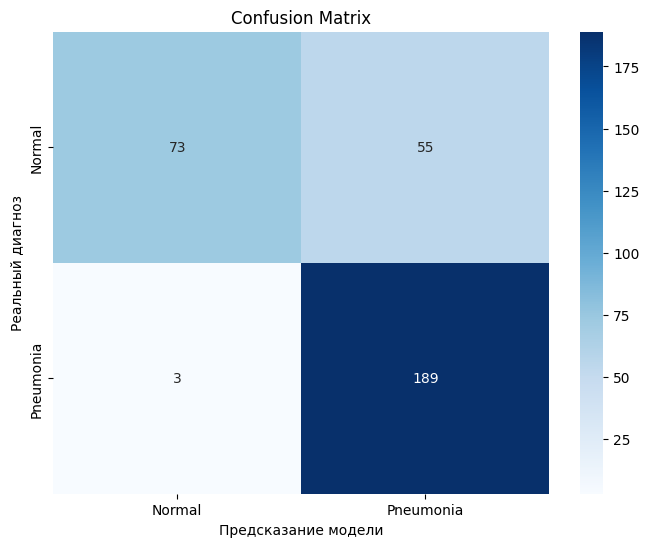

              precision    recall  f1-score   support

      Normal       0.96      0.57      0.72       128
   Pneumonia       0.77      0.98      0.87       192

    accuracy                           0.82       320
   macro avg       0.87      0.78      0.79       320
weighted avg       0.85      0.82      0.81       320



In [72]:
analyze_model_performance(model_v2, val_loader, device, threshold=0.98)

In [34]:
model_v3 = PneumoniaCNN_v2().to(device)

In [38]:
weights = torch.tensor([2.5, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(model_v3.parameters(), lr=0.0001, weight_decay=1e-3)

In [39]:
best_val_loss = float('inf')
patience = 3
counter = 0
epochs = 10
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model_v3, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model_v3, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    print('-' * 30)


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_v3.state_dict(), 'best_model.pth')
        print(f"--- Модель сохранена! (Val Loss: {best_val_loss:.4f}) ---")
        counter = 0
    else:
        counter += 1
        print(f"--- Улучшений нет. Счетчик: {counter}/{patience} ---")

    if counter >= patience:
        print("Останавливаем обучение: модель перестала улучшаться.")
        break

Epoch 1/10:
Train Loss: 0.5681 | Train Acc: 71.40%
Val Loss: 0.7622 | Val Acc: 65.94%
------------------------------
--- Модель сохранена! (Val Loss: 0.7622) ---
Epoch 2/10:
Train Loss: 0.4143 | Train Acc: 84.93%
Val Loss: 0.5677 | Val Acc: 78.44%
------------------------------
--- Модель сохранена! (Val Loss: 0.5677) ---
Epoch 3/10:
Train Loss: 0.3352 | Train Acc: 87.52%
Val Loss: 0.5213 | Val Acc: 80.94%
------------------------------
--- Модель сохранена! (Val Loss: 0.5213) ---
Epoch 4/10:
Train Loss: 0.2788 | Train Acc: 89.93%
Val Loss: 0.5703 | Val Acc: 81.88%
------------------------------
--- Улучшений нет. Счетчик: 1/3 ---
Epoch 5/10:
Train Loss: 0.2455 | Train Acc: 91.12%
Val Loss: 0.8014 | Val Acc: 73.75%
------------------------------
--- Улучшений нет. Счетчик: 2/3 ---
Epoch 6/10:
Train Loss: 0.2369 | Train Acc: 90.89%
Val Loss: 0.7689 | Val Acc: 78.12%
------------------------------
--- Улучшений нет. Счетчик: 3/3 ---
Останавливаем обучение: модель перестала улучшаться.


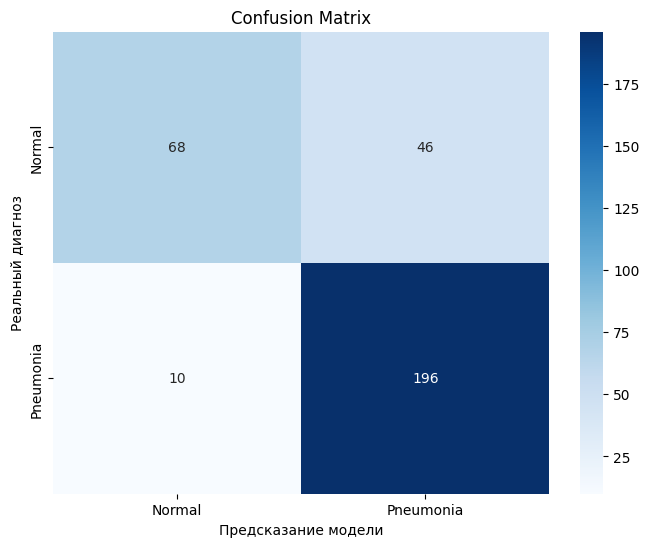

              precision    recall  f1-score   support

      Normal       0.87      0.60      0.71       114
   Pneumonia       0.81      0.95      0.88       206

    accuracy                           0.82       320
   macro avg       0.84      0.77      0.79       320
weighted avg       0.83      0.82      0.82       320



In [75]:
analyze_model_performance(model_v3, test_loader, device, threshold=0.65)

In [54]:
from sklearn.metrics import precision_recall_curve, auc, classification_report
import matplotlib.pyplot as plt

def evaluate_final(model, loader, device):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.inference_mode():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(outputs.argmax(1).cpu().numpy())

    precision, recall, _ = precision_recall_curve(all_labels, all_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'PR Curve (area = {auc(recall, precision):.2f})')
    plt.xlabel('Recall (Чувствительность)')
    plt.ylabel('Precision (Точность)')
    plt.title('Pneumonia Detection PR Curve')
    plt.legend()
    plt.show()

    print(classification_report(all_labels, all_preds, target_names=['Normal', 'Pneumonia']))

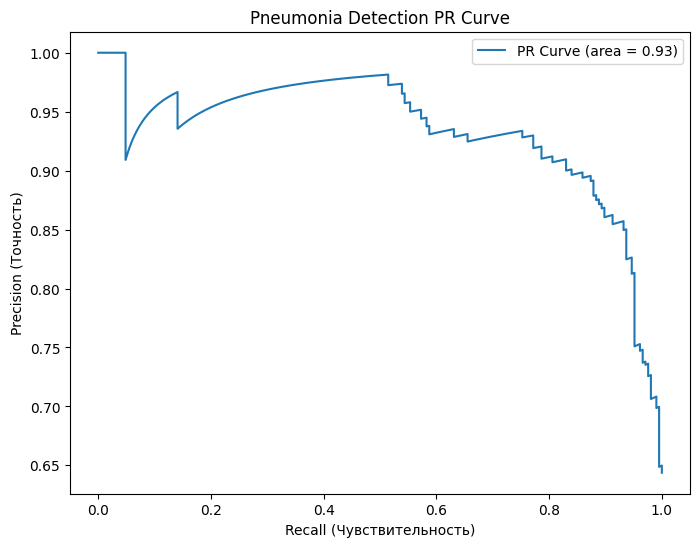

              precision    recall  f1-score   support

      Normal       0.84      0.47      0.61       114
   Pneumonia       0.77      0.95      0.85       206

    accuracy                           0.78       320
   macro avg       0.80      0.71      0.73       320
weighted avg       0.79      0.78      0.76       320



In [51]:
evaluate_final(model_v3, test_loader, device)

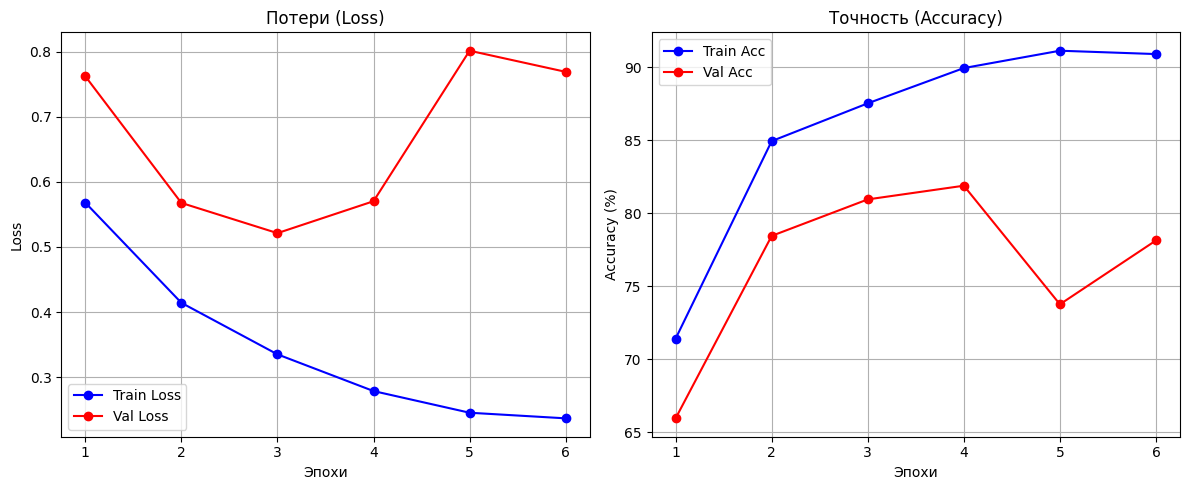

In [52]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Val Loss')
    plt.title('Потери (Loss)')
    plt.xlabel('Эпохи')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Val Acc')
    plt.title('Точность (Accuracy)')
    plt.xlabel('Эпохи')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

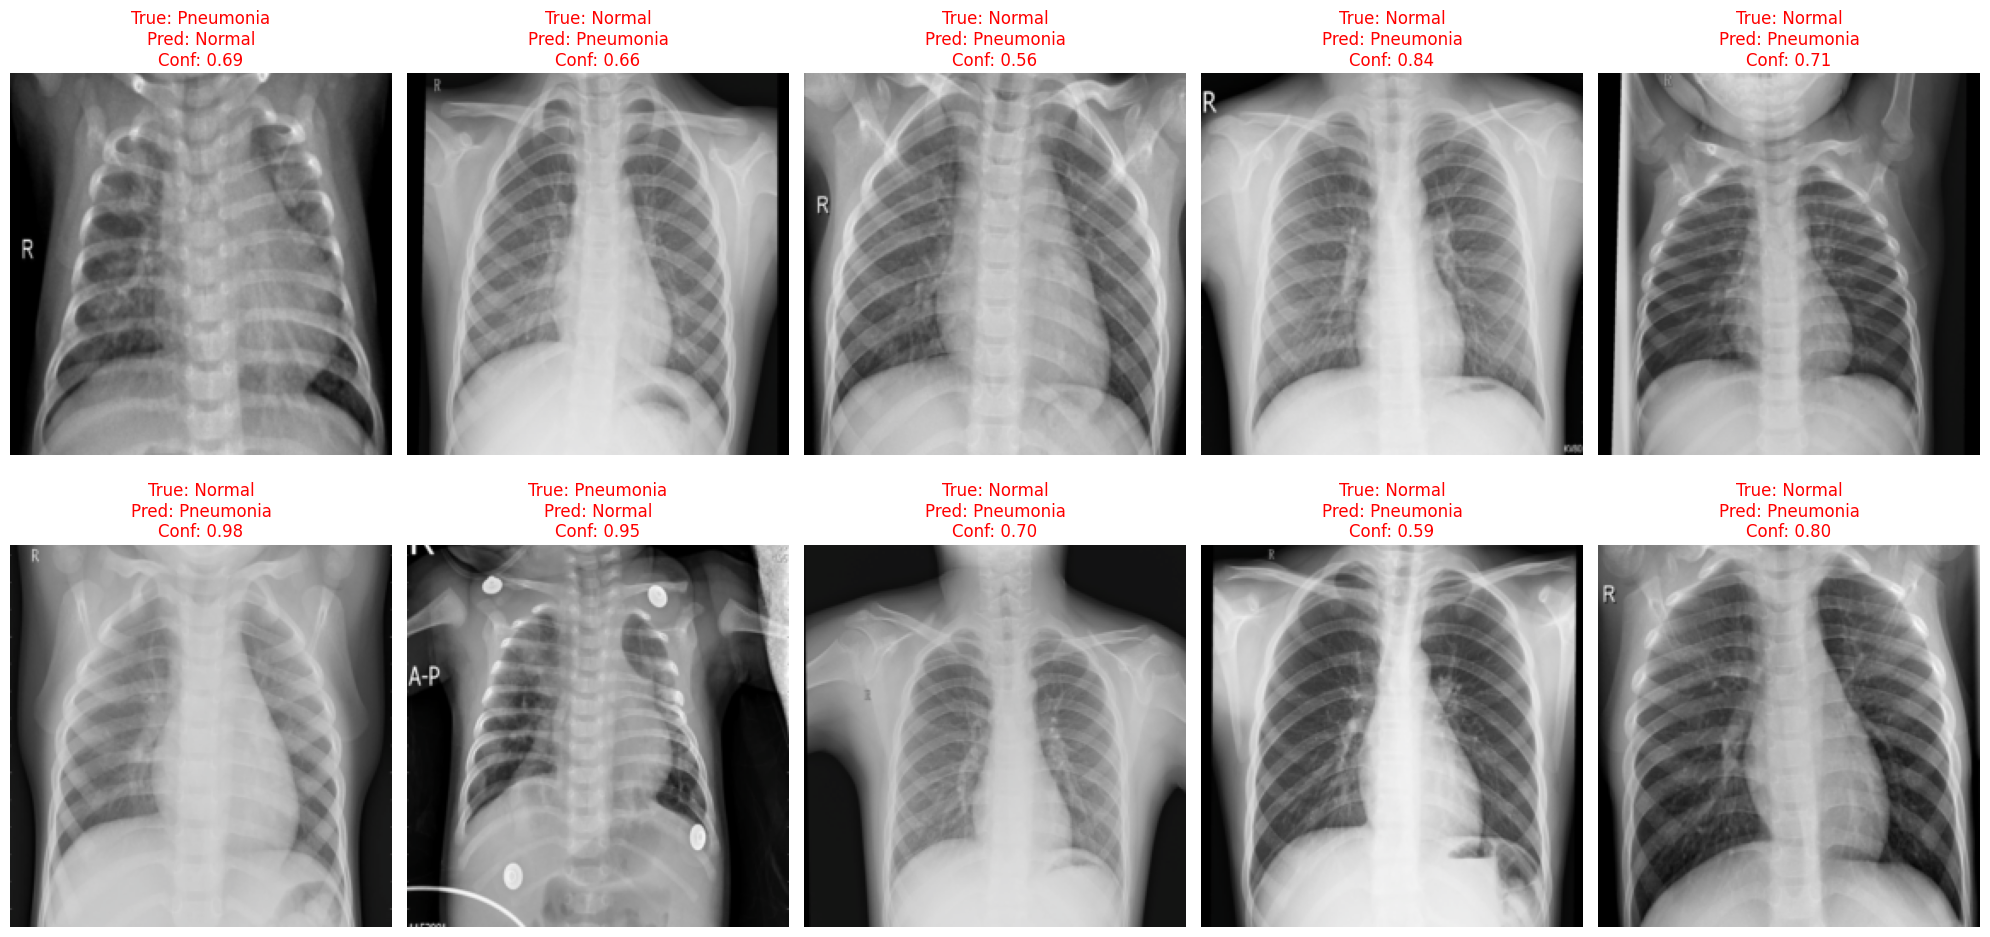

In [64]:


def visualize_errors(model, loader, device, n_images=10):
    model.eval()
    errors = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)

            wrong_idx = (preds != labels).nonzero(as_tuple=False)

            for idx in wrong_idx:
                i = idx.item()
                errors.append({
                    'image': inputs[i].cpu(),
                    'true': labels[i].item(),
                    'pred': preds[i].item(),
                    'prob': probs[i][preds[i]].item()
                })

            if len(errors) >= n_images:
                break

    plt.figure(figsize=(20, 10))
    classes = ['Normal', 'Pneumonia']

    for i, error in enumerate(errors[:n_images]):
        img = error['image'].permute(1, 2, 0).numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = np.clip(img, 0, 1)

        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        title = f"True: {classes[error['true']]}\nPred: {classes[error['pred']]}\nConf: {error['prob']:.2f}"
        plt.title(title, color='red' if error['true'] != error['pred'] else 'black')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_errors(model_v3, test_loader, device)

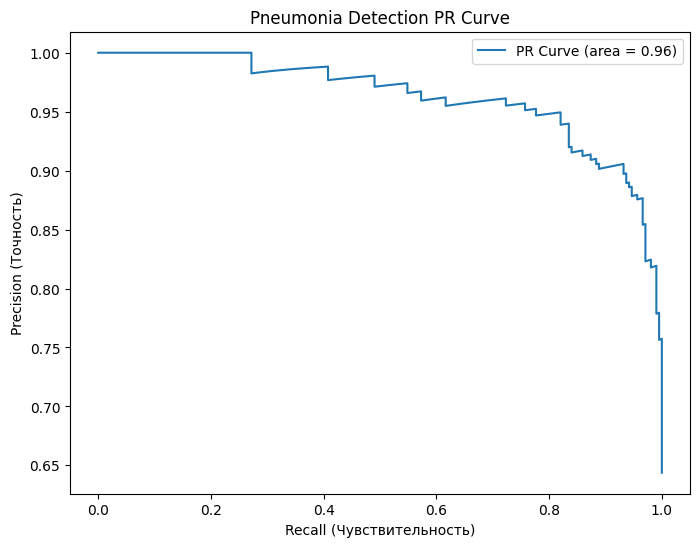

              precision    recall  f1-score   support

      Normal       1.00      0.15      0.26       114
   Pneumonia       0.68      1.00      0.81       206

    accuracy                           0.70       320
   macro avg       0.84      0.57      0.53       320
weighted avg       0.79      0.70      0.61       320



In [76]:
evaluate_final(model_v2, test_loader, device)